In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

# What does human power output with time look like?

Import time to exhaustion data

In [2]:
import pandas as pd
from carpy.utility import GetPath, cast2quantity

# Read the data from the relevant file
excel_path = os.path.join(GetPath.library(), "propulsion\\data\\cycling_exhaustion_malewicki.xlsx")
dfs = pd.read_excel(excel_path, sheet_name=None)

data_healthy = cast2quantity(dfs["healthy"])
data_athlete = cast2quantity(dfs["athlete"])

Create power models

In [3]:
import numpy as np
from carpy.utility import Quantity
from scipy.optimize import curve_fit

def func(x, a, b, c):
    """Exponential model with controlling parameters a, b, and c."""
    return a * np.exp(-b * (x - c))

def cnuf(y, a, b, c):
    """Inverse of func."""
    return np.log(y / a) / -b + c

# Model parameters for a healthy human's sustained power output
p0 = (1, 1e-2, max(data_healthy["power"]).x)
popt_healthy, _ = curve_fit(func, data_healthy["power"], data_healthy["time"], p0=p0)

# Model parameters for an athlete's sustained power output
p0 = (1, 1e-2, max(data_athlete["power"]).x)
popt_athlete, _ = curve_fit(func, data_athlete["power"], data_athlete["time"], p0=p0)

Visualise the chart to make sure our models make sense

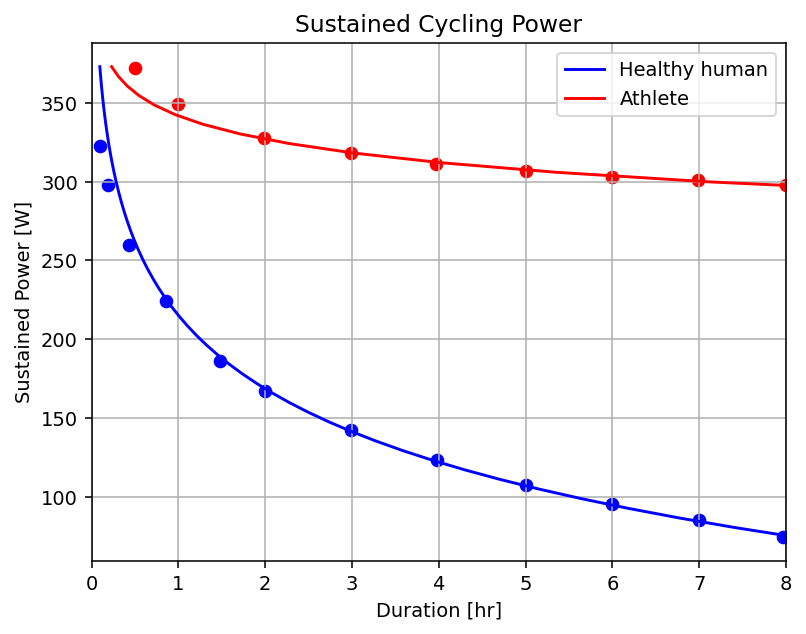

In [4]:
power = Quantity(np.linspace(0.1, 0.5), "hp")
time_healthy = Quantity(func(power.to("W"), *popt_healthy), "s")
time_athlete = Quantity(func(power.to("W"), *popt_athlete), "s")

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, dpi=140)

# Plot raw data
ax.scatter(data_healthy["time"].to("hr"), data_healthy["power"], c="blue")
ax.scatter(data_athlete["time"].to("hr"), data_athlete["power"], c="red")

# Plot models
ax.plot(time_healthy.to("hr"), power, c="blue", label="Healthy human")
ax.plot(time_athlete.to("hr"), power, c="red", label="Athlete")

ax.set_xlim(0, 8)
ax.set_title("Sustained Cycling Power")
ax.set_xlabel("Duration [hr]")
ax.set_ylabel("Sustained Power [W]")
ax.legend()
ax.grid()
plt.show()

# Is Malewicki's performance model feasible?

Import cyclist performance data by demographic

In [5]:
import pandas as pd

# Read the data from the relevant file
excel_path = os.path.join(GetPath.library(), "propulsion\\data\\cyclinganalytics_power.xlsx")
dfs = pd.read_excel(excel_path, sheet_name=None)

data_men = cast2quantity(dfs["M W"])
data_women = cast2quantity(dfs["F W"])

Plot the percentile of athlete you need to be, to sustain a cycling output of however many watts

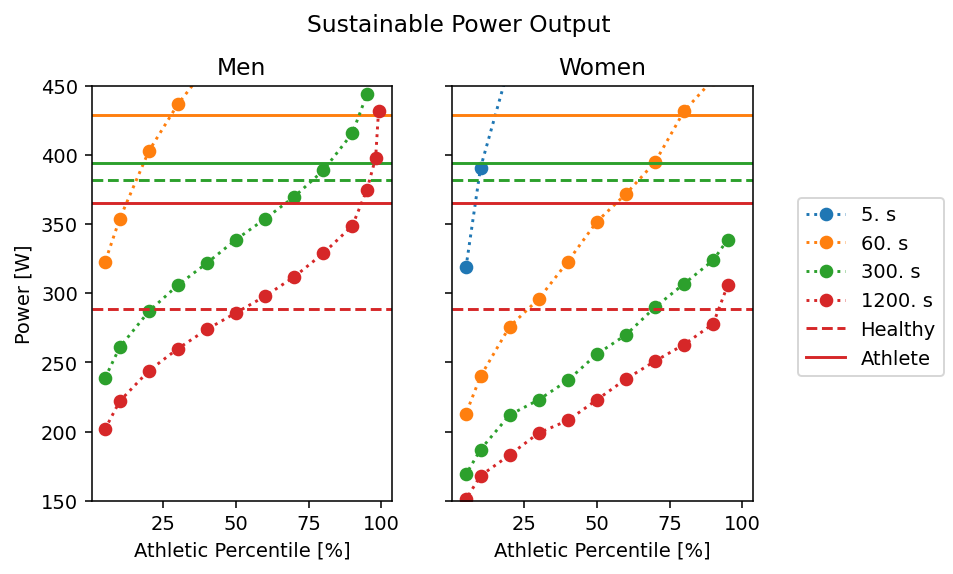

In [6]:
fig, axs = plt.subplots(1, 2, dpi=140, figsize=(7, 4), sharex=True, sharey=True)
fig.suptitle("Sustainable Power Output")
fig.subplots_adjust(top=0.85, right=0.8)

times = Quantity([5, 60, 300, 1200], "s")

for i, dataset in enumerate([data_men, data_women]):
    # Plot series data
    for time in times:
        series = f"{int(time.x)}s"
        line, = axs[i].plot(dataset["percentile [%]"], dataset[series], label=time, ls=":", marker="o")
    
        # The power Malewicki thinks a healthy human can produce for the given time
        p = Quantity(cnuf(time, *popt_healthy), "s")
        line_h = axs[i].axhline(p, ls="--", c=line.get_color())

        # The power Malewicki thinks an athletic human can produce for the given time
        p = Quantity(cnuf(time, *popt_athlete), "s")
        line_a = axs[i].axhline(p, ls="-", c=line.get_color())
        
# Make plot pretty
for ax in axs.flat:
    ax.set_xlabel("Athletic Percentile [%]")
else:
    axs[0].set_title("Men")
    axs[1].set_title("Women")
    axs[0].set_ylabel("Power [W]")
    axs[0].set_ylim(150, 450)
    
    handles, labels = ax.get_legend_handles_labels()
    handles += [line_h, line_a]
    labels += ["Healthy", "Athlete"]
    fig.legend(handles=handles, labels=labels, loc="right")
    
plt.show()

The graphs appear to show that men in the 52% performance percentile and women in the 92% performance percentile meet Malewicki's estimation for a "healthy human"'s power output for 20 minutes.
To meet Malewicki's estimation for an athlete's power output over 20 minutes, you need a man in the top 92% performance percentile. 

# What is the available sustained power for a channel crossing?

Work out the times that it would take to cross the channel at the shortest point, with no wind

In [7]:
channel_dist = Quantity(20.5, "mi")
crossing_speeds = Quantity(np.linspace(0, 15), "m s^{-1}")

crossing_times = channel_dist / crossing_speeds

Plot the crossing speed and the power available for a given crossing time

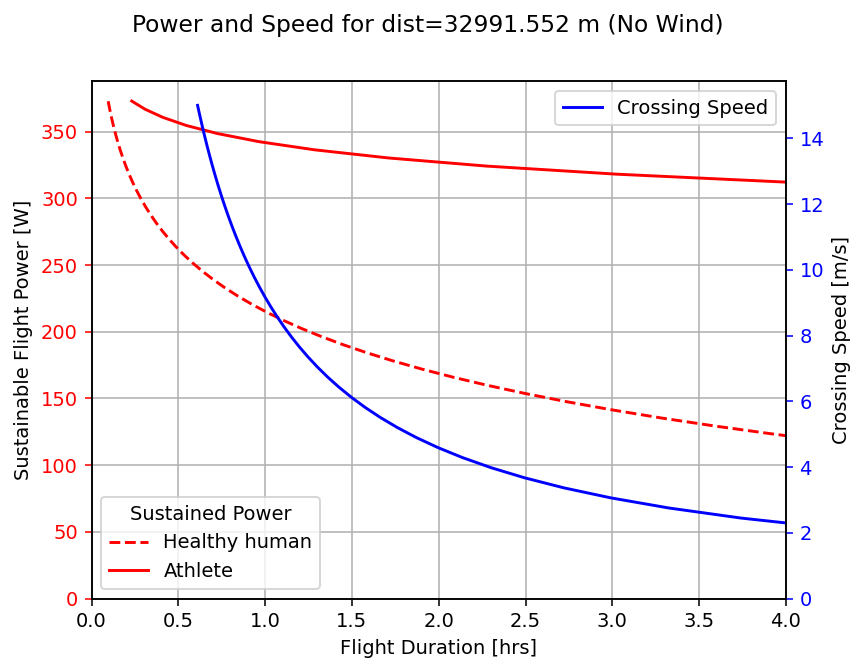

In [9]:
fig, ax = plt.subplots(1, dpi=140)
fig.suptitle(f"Power and Speed for dist={channel_dist} (No Wind)")
ax2 = ax.twinx()

line_p, = ax.plot(time_healthy.to("hr"), power.to("W"), c="red", ls="--", label="Healthy human")
ax.plot(time_athlete.to("hr"), power.to("W"), c="red", ls="-", label="Athlete")

line_t, = ax2.plot(crossing_times.to("hr"), crossing_speeds, ls="-", c="blue", label="Crossing Speed")

# Make axis 1 pretty
ax.set_xlim(0, 4)
ax.set_ylim(0, None)
ax.set_xlabel("Flight Duration [hrs]")
ax.set_ylabel("Sustainable Flight Power [W]")
ax.tick_params(axis="y", colors=line_p.get_color())

# Make axis 2 pretty
ax2.set_ylim(0, None)
ax2.set_ylabel("Crossing Speed [m/s]")
ax2.tick_params(axis="y", colors=line_t.get_color())

ax.legend(title="Sustained Power", loc="lower left")
ax2.legend(loc="upper right")
ax.grid()
plt.show()